In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import hdbscan

In [2]:
ctu13 = pd.read_csv('~/PycharmProjects/botnet_detection-by_unsupervised_labeling/Unsupervised-Labeling-/complete_all_scenarios_NoTransfer_withHeader_withLabel-26-1-2021-bak.csv')
ctu13 = ctu13.sample(n=300)
ctu13 = ctu13.drop(['sTtl'], axis=1)

/home/sudip/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
ctu13_1 = ctu13

# Replace the label of normal traffic with 0
ctu13_1.loc[ctu13_1['Label'].str.contains('Normal') == True, 'Label'] = 0

# Replace the label of abnormal/botnet traffic with 1
ctu13_1.loc[ctu13_1['Label'].str.contains('Botnet') == True, 'Label'] = 1

In [4]:
# ctu13_1.to_csv(r'/home/sudip/PycharmProjects/pythonProject/binLabel.csv')
ctu13_1

,Dur,SrcDur,DstDur,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,TotBytes,...,SrcRate,DstRate,sMaxPktSz,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-
429887,0.000324,0,0,63.0,1,1.0,2,1,1,400,...,0.000000,0.000000,74,74,326.0,326.0,0,0,1,0
98207,0.25624,0.247411,0.247463,53.0,1,11.0,15,7,8,2044,...,24.251144,28.287056,363,66,549.0,66.0,0,1,0,0
64293,0.139277,0.093618,0.09326,54.0,1,10.0,10,5,5,1451,...,42.726826,42.890842,459,60,508.0,60.0,1,1,0,0
383106,0.000411,0.0,0,63.0,1,1.0,2,1,1,384,...,0.000000,0.000000,71,71,313.0,313.0,1,0,1,0
125729,0.246122,0.237364,0.237236,55.0,1,9.0,16,8,8,2677,...,29.490572,29.506483,584,66,895.0,66.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117554,0.278759,0.267298,0.269789,53.0,1,11.0,16,8,8,2649,...,26.187998,25.946201,564,66,887.0,66.0,0,1,0,0
52060,49.100746,49.084572,49.084682,56.0,1,8.0,26,10,16,18931,...,0.183357,0.305594,555,66,1514.0,66.0,0,1,0,0
233210,64.354698,64.354698,63.920341,106.0,1,22.0,11,7,4,1136,...,0.093233,0.046933,135,60,457.0,60.0,1,1,0,0
176637,0.00043,0,0,63.0,1,1.0,2,1,1,211,...,0.000000,0.000000,77,77,134.0,134.0,0,0,1,0


In [5]:
def dataset_cleaning(df):
    cols = df.columns
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Fill nans with median values
    df.fillna(df.median(), inplace=True)
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=cols)
    return df_scaled

In [6]:
ctu13_scaled = dataset_cleaning(ctu13)

ctu13_scaled

,Dur,SrcDur,DstDur,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,TotBytes,...,SrcRate,DstRate,sMaxPktSz,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-
0,1.086465e-07,0.000000,0.000000,0.099502,0.5,0.000000,0.001259,0.000000,0.002062,0.000495,...,0.000000,0.000000,0.008264,0.009629,0.182944,0.264414,0.0,0.0,1.0,0.0
1,8.592461e-05,0.000083,0.000102,0.049751,0.5,0.277778,0.017632,0.019417,0.016495,0.002968,...,0.021846,0.020637,0.207300,0.004127,0.336314,0.005964,0.0,1.0,0.0,0.0
2,4.670357e-05,0.000031,0.000038,0.054726,0.5,0.250000,0.011335,0.012945,0.010309,0.002076,...,0.038490,0.031292,0.273416,0.000000,0.308116,0.000000,1.0,1.0,0.0,0.0
3,1.378201e-07,0.000000,0.000000,0.099502,0.5,0.000000,0.001259,0.000000,0.002062,0.000471,...,0.000000,0.000000,0.006198,0.007565,0.174003,0.251491,1.0,0.0,1.0,0.0
4,8.253175e-05,0.000080,0.000097,0.059701,0.5,0.222222,0.018892,0.022654,0.016495,0.003920,...,0.026566,0.021527,0.359504,0.004127,0.574278,0.005964,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,9.347587e-05,0.000090,0.000111,0.049751,0.5,0.277778,0.018892,0.022654,0.016495,0.003878,...,0.023591,0.018930,0.345730,0.004127,0.568776,0.005964,0.0,1.0,0.0,0.0
296,1.646489e-02,0.016460,0.020146,0.064677,0.5,0.194444,0.031486,0.029126,0.032990,0.028373,...,0.000165,0.000223,0.339532,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0
297,2.157997e-02,0.021580,0.026235,0.313433,0.5,0.583333,0.012594,0.019417,0.008247,0.001602,...,0.000084,0.000034,0.050275,0.000000,0.273040,0.000000,1.0,1.0,0.0,0.0
298,1.441913e-07,0.000000,0.000000,0.099502,0.5,0.000000,0.001259,0.000000,0.002062,0.000211,...,0.000000,0.000000,0.010331,0.011692,0.050894,0.073559,0.0,0.0,1.0,0.0


In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=8, gen_min_span_tree=True).fit(ctu13_scaled.drop(['Label'], axis=1))
clusterer.labels_

array([ 0,  3, -1,  0,  2, -1,  6, -1,  0,  5,  7,  8,  0,  0,  0,  7,  0,
        0,  5,  9,  7, -1,  0,  0,  0,  0,  3,  2,  0,  9,  0,  6,  0,  6,
        1,  4,  0, -1, -1,  8,  0,  6,  9, -1,  0, -1,  8, -1,  3,  0,  7,
       -1,  5,  0,  0, -1, -1,  0,  0,  0,  0,  9,  0,  0,  0, -1, -1, -1,
        0,  3,  0,  4,  3, -1,  0,  1,  0,  0,  0,  7,  8,  6,  0,  0,  0,
        0,  8,  3, -1, -1, -1,  0,  0,  6, -1,  0, -1,  0,  0, -1,  6, -1,
        2,  0,  8,  0,  0,  2,  6,  7,  4,  0,  2,  3,  0,  8,  0,  2,  6,
       -1,  1,  0,  1,  0,  1,  0,  5,  0,  4, -1,  5,  7,  8,  0,  0,  0,
        0,  5, -1, -1,  0, -1,  4,  0,  0,  0,  0,  0,  0,  6, -1,  0,  0,
        7,  2,  0, -1,  0,  5, -1,  5, -1,  0,  0,  0,  2,  7,  7,  0, -1,
       -1,  0,  0,  0, -1,  5,  6,  0, -1,  4,  5,  4,  6, -1,  0, -1,  7,
        0, -1,  5,  9,  0,  0, -1,  3,  0,  0, -1, -1,  7,  0,  6,  3,  3,
        0,  7,  1,  0,  9,  0,  6,  8,  9,  0, -1,  6,  0,  4, -1,  0,  0,
        7,  6,  4, -1, -1

In [8]:
print(np.shape(clusterer.labels_))

(300,)


In [9]:
clusterer.probabilities_

array([5.64851587e-01, 1.00000000e+00, 0.00000000e+00, 5.66798995e-01,
       9.99123013e-01, 0.00000000e+00, 7.87766985e-06, 0.00000000e+00,
       8.10633385e-01, 1.00000000e+00, 9.69480444e-01, 1.00000000e+00,
       8.63121978e-01, 1.00000000e+00, 1.00000000e+00, 9.73339239e-01,
       3.19578326e-01, 9.91729621e-01, 1.00000000e+00, 1.00000000e+00,
       7.87046024e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.44619655e-01, 1.00000000e+00, 9.16328924e-01, 1.00000000e+00,
       4.71543829e-01, 7.93349286e-01, 9.65892198e-01, 1.00000000e+00,
       7.25099815e-02, 8.05326243e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.80445620e-01,
       6.14478225e-02, 1.00000000e+00, 8.53627485e-01, 0.00000000e+00,
       8.14546067e-01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 4.42339156e-01, 8.73792412e-01, 0.00000000e+00,
       1.88891561e-01, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
      

In [10]:
print(np.shape(clusterer.probabilities_))

(300,)


In [11]:
x = np.resize(clusterer.labels_, (len(clusterer.labels_), 1))
prob = np.resize(clusterer.probabilities_, (len(clusterer.probabilities_), 1))
# Add the cluster number to the dataframe
ctu13_scaled['Cluster no.'] = x
ctu13_scaled['Prob'] = prob

In [12]:
ctu13_scaled

,Dur,SrcDur,DstDur,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,TotBytes,...,sMaxPktSz,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-,Cluster no.,Prob
0,1.086465e-07,0.000000,0.000000,0.099502,0.5,0.000000,0.001259,0.000000,0.002062,0.000495,...,0.008264,0.009629,0.182944,0.264414,0.0,0.0,1.0,0.0,0,0.564852
1,8.592461e-05,0.000083,0.000102,0.049751,0.5,0.277778,0.017632,0.019417,0.016495,0.002968,...,0.207300,0.004127,0.336314,0.005964,0.0,1.0,0.0,0.0,3,1.000000
2,4.670357e-05,0.000031,0.000038,0.054726,0.5,0.250000,0.011335,0.012945,0.010309,0.002076,...,0.273416,0.000000,0.308116,0.000000,1.0,1.0,0.0,0.0,-1,0.000000
3,1.378201e-07,0.000000,0.000000,0.099502,0.5,0.000000,0.001259,0.000000,0.002062,0.000471,...,0.006198,0.007565,0.174003,0.251491,1.0,0.0,1.0,0.0,0,0.566799
4,8.253175e-05,0.000080,0.000097,0.059701,0.5,0.222222,0.018892,0.022654,0.016495,0.003920,...,0.359504,0.004127,0.574278,0.005964,0.0,1.0,0.0,0.0,2,0.999123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,9.347587e-05,0.000090,0.000111,0.049751,0.5,0.277778,0.018892,0.022654,0.016495,0.003878,...,0.345730,0.004127,0.568776,0.005964,0.0,1.0,0.0,0.0,2,1.000000
296,1.646489e-02,0.016460,0.020146,0.064677,0.5,0.194444,0.031486,0.029126,0.032990,0.028373,...,0.339532,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.000000
297,2.157997e-02,0.021580,0.026235,0.313433,0.5,0.583333,0.012594,0.019417,0.008247,0.001602,...,0.050275,0.000000,0.273040,0.000000,1.0,1.0,0.0,0.0,-1,0.000000
298,1.441913e-07,0.000000,0.000000,0.099502,0.5,0.000000,0.001259,0.000000,0.002062,0.000211,...,0.010331,0.011692,0.050894,0.073559,0.0,0.0,1.0,0.0,0,1.000000


In [13]:
ctu13_scaled.to_csv("~/PycharmProjects/botnet_detection-by_unsupervised_labeling/Unsupervised-Labeling-/Notebooks/df_nCL.csv")

<AxesSubplot:ylabel='$\\lambda$ value'>

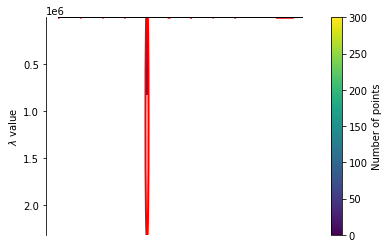

In [14]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [15]:
clusterer.condensed_tree_.to_pandas()

,parent,child,lambda_val,child_size
0,300,139,0.386533,1
1,300,65,0.472813,1
2,300,188,0.657319,1
3,300,55,0.674640,1
4,300,242,0.692867,1
...,...,...,...,...
317,321,85,80.530518,1
318,321,98,80.530518,1
319,321,82,80.530518,1
320,321,91,80.530518,1


In [16]:
centers = clusterer.exemplars_

In [17]:
print(np.shape(clusterer.exemplars_))

(10,)


/home/sudip/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [18]:
centers[0]

array([[3.87140258e-05, 0.00000000e+00, 0.00000000e+00, 9.95024876e-02,
        5.00000000e-01, 0.00000000e+00, 1.25944584e-03, 0.00000000e+00,
        2.06185567e-03, 2.36189319e-04, 1.09497843e-04, 2.44660596e-04,
        2.35204187e-04, 3.43965695e-04, 1.88243065e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.47248616e-04, 0.00000000e+00,
        0.00000000e+00, 6.88705234e-03, 8.25309491e-03, 6.60247593e-02,
        9.54274354e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.03215857e-04, 0.00000000e+00, 0.00000000e+00, 9.95024876e-02,
        5.00000000e-01, 0.00000000e+00, 1.25944584e-03, 0.00000000e+00,
        2.06185567e-03, 2.36189319e-04, 1.97096117e-04, 2.32113899e-04,
        2.35204187e-04, 4.35689881e-04, 1.75033025e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.80518880e-05, 0.00000000e+00,
        0.00000000e+00, 1.23966942e-02, 1.37551582e-02, 6.05226960e-02,
        8.74751491e-02, 0.00000000e+00, 1.00000000e+00, 0.00000

In [19]:
print(np.shape(centers))

(10,)


In [20]:
print(np.dtype(clusterer.relative_validity_))

float64


In [21]:
np.median(centers[0])

0.00020015598722339568

In [22]:
clf_name = str(type(clusterer)).split(".")[-1][:-2]

In [23]:
ctu13_2 = pd.read_csv('~/PycharmProjects/botnet_detection-by_unsupervised_labeling/Unsupervised-Labeling-/complete_all_scenarios_NoTransfer_withHeader_withLabel-26-1-2021-bak.csv')
ctu13_2 = ctu13_2.sample(n=300)
ctu13_2['Label'].str.contains('Normal')

/home/sudip/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


436474    False
426440     True
472517    False
298926    False
494633     True
          ...  
379549    False
272027    False
43058      True
243259     True
396331    False
Name: Label, Length: 300, dtype: bool

In [24]:
mask = ctu13_scaled['Prob'].where(ctu13_scaled['Prob']==1)
mask==1

0      False
1       True
2      False
3      False
4      False
       ...  
295     True
296     True
297    False
298     True
299    False
Name: Prob, Length: 300, dtype: bool

In [25]:
ctu13_scaled['Cluster no.'].max()

9

In [26]:
for i in range(ctu13_scaled['Cluster no.'].max()+1):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [27]:
df = ctu13_scaled.loc[ctu13_scaled['Cluster no.']==1]
df

,Dur,SrcDur,DstDur,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,TotBytes,...,sMaxPktSz,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-,Cluster no.,Prob
34,0.002536,0.002531,0.003098,0.064677,0.5,0.194444,0.037783,0.048544,0.030928,0.024091,...,0.276171,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0,1,1.000000
75,0.006398,0.006398,0.007830,0.059701,0.5,0.222222,0.015113,0.019417,0.012371,0.004491,...,0.447658,0.000000,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.000000
120,0.000109,0.000106,0.000130,0.059701,0.5,0.222222,0.026448,0.029126,0.024742,0.007188,...,0.219697,0.004127,0.979367,0.005964,0.0,1.0,0.0,0.0,1,1.000000
122,0.053926,0.053925,0.066002,0.059701,0.5,0.222222,0.045340,0.055016,0.039175,0.022119,...,0.506198,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,0.967491
124,0.003021,0.003021,0.000000,0.054726,0.5,0.250000,0.002519,0.006472,0.000000,0.000173,...,0.000000,0.001376,1.000000,0.000000,1.0,1.0,0.0,0.0,1,0.874596
206,0.000101,0.000100,0.000123,0.069652,0.5,0.166667,0.027708,0.029126,0.026804,0.024006,...,0.449036,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.000000
241,0.003360,0.003360,0.000091,0.059701,0.5,0.222222,0.017632,0.025890,0.012371,0.005578,...,0.155647,0.004127,0.979367,0.005964,0.0,1.0,0.0,0.0,1,1.000000
246,0.004483,0.004483,0.005487,0.064677,0.5,0.194444,0.093199,0.113269,0.080412,0.078662,...,0.459366,0.004127,0.944979,0.005964,0.0,1.0,0.0,0.0,1,0.955098
256,0.001616,0.001616,0.001418,0.064677,0.5,0.194444,0.015113,0.019417,0.012371,0.006935,...,0.213499,0.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,1,1.000000
280,0.010079,0.010079,0.000005,0.059701,0.5,0.222222,0.012594,0.019417,0.008247,0.004343,...,0.159091,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,0.880952


In [28]:
df1=df.loc[df['Prob']==1]

n_queries = len(df1)
df1

,Dur,SrcDur,DstDur,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,TotBytes,...,sMaxPktSz,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-,Cluster no.,Prob
34,0.002536,0.002531,0.003098,0.064677,0.5,0.194444,0.037783,0.048544,0.030928,0.024091,...,0.276171,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0,1,1.0
75,0.006398,0.006398,0.007830,0.059701,0.5,0.222222,0.015113,0.019417,0.012371,0.004491,...,0.447658,0.000000,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.0
120,0.000109,0.000106,0.000130,0.059701,0.5,0.222222,0.026448,0.029126,0.024742,0.007188,...,0.219697,0.004127,0.979367,0.005964,0.0,1.0,0.0,0.0,1,1.0
206,0.000101,0.000100,0.000123,0.069652,0.5,0.166667,0.027708,0.029126,0.026804,0.024006,...,0.449036,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.0
241,0.003360,0.003360,0.000091,0.059701,0.5,0.222222,0.017632,0.025890,0.012371,0.005578,...,0.155647,0.004127,0.979367,0.005964,0.0,1.0,0.0,0.0,1,1.0
256,0.001616,0.001616,0.001418,0.064677,0.5,0.194444,0.015113,0.019417,0.012371,0.006935,...,0.213499,0.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,1,1.0
296,0.016465,0.016460,0.020146,0.064677,0.5,0.194444,0.031486,0.029126,0.032990,0.028373,...,0.339532,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.0


In [29]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def is_unique(s):
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a).all()
df['new_label']=0
if is_unique(df1['Label']):
    df['new_label'] = df1['Label'].iloc[0]
    n_query = len(df1['Label'])
else:
    df['new_label'] = df['Label']
    n_query = len(df['Label'])
    

In [30]:
df

,Dur,SrcDur,DstDur,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,TotBytes,...,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-,Cluster no.,Prob,new_label
34,0.002536,0.002531,0.003098,0.064677,0.5,0.194444,0.037783,0.048544,0.030928,0.024091,...,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0,1,1.000000,0.0
75,0.006398,0.006398,0.007830,0.059701,0.5,0.222222,0.015113,0.019417,0.012371,0.004491,...,0.000000,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.000000,0.0
120,0.000109,0.000106,0.000130,0.059701,0.5,0.222222,0.026448,0.029126,0.024742,0.007188,...,0.004127,0.979367,0.005964,0.0,1.0,0.0,0.0,1,1.000000,0.0
122,0.053926,0.053925,0.066002,0.059701,0.5,0.222222,0.045340,0.055016,0.039175,0.022119,...,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,0.967491,0.0
124,0.003021,0.003021,0.000000,0.054726,0.5,0.250000,0.002519,0.006472,0.000000,0.000173,...,0.001376,1.000000,0.000000,1.0,1.0,0.0,0.0,1,0.874596,1.0
206,0.000101,0.000100,0.000123,0.069652,0.5,0.166667,0.027708,0.029126,0.026804,0.024006,...,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,1.000000,0.0
241,0.003360,0.003360,0.000091,0.059701,0.5,0.222222,0.017632,0.025890,0.012371,0.005578,...,0.004127,0.979367,0.005964,0.0,1.0,0.0,0.0,1,1.000000,0.0
246,0.004483,0.004483,0.005487,0.064677,0.5,0.194444,0.093199,0.113269,0.080412,0.078662,...,0.004127,0.944979,0.005964,0.0,1.0,0.0,0.0,1,0.955098,0.0
256,0.001616,0.001616,0.001418,0.064677,0.5,0.194444,0.015113,0.019417,0.012371,0.006935,...,0.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,1,1.000000,1.0
280,0.010079,0.010079,0.000005,0.059701,0.5,0.222222,0.012594,0.019417,0.008247,0.004343,...,0.004127,1.000000,0.005964,0.0,1.0,0.0,0.0,1,0.880952,0.0


In [44]:
    def find_majority_elem(k):
        myMap = {}
        maj_elem_cnt = ['', 0]  # (occurring element, occurrences)
        th = 0.81  # Set a threshold for majority selection (90%)
        for n in k:
            if n in myMap:
                myMap[n] += 1
            else:
                myMap[n] = 1
            # Keep track of maximum on the go
            if myMap[n] > maj_elem_cnt[1]: maj_elem_cnt = [n, myMap[n]]
#         min_elem_cnt = len(k.index) - maj_elem_cnt[1]  # occurrence of the element with less count
        if maj_elem_cnt[1]/len(k.index) < th:
            maj_elem = None
        else:
            maj_elem = maj_elem_cnt[0]
        return maj_elem
    
    
    maj_elem = find_majority_elem(df['Label'])
    print(maj_elem)

0.0
